In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import os
import datetime

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# sklearn stuff
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import feature_pipelines as pipes

In [2]:
maindir = "/home/anerdi/Desktop/Zillow"

logerror = pd.read_csv(maindir + "/data/train_2016_v2.csv/train_2016_v2.csv")
logerror['weeknumber'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isocalendar()[1])
logerror['month'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)
properties = pd.read_csv(maindir + "/data/properties_2016.csv/properties_2016.csv")

/home/anerdi/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#proportion of living area
properties['N-LivingAreaProp'] = properties['calculatedfinishedsquarefeet']/properties['lotsizesquarefeet']

#Ratio of the built structure value to land area
properties['N-ValueProp'] = properties['structuretaxvaluedollarcnt']/properties['landtaxvaluedollarcnt']

#Ratio of tax of property over parcel
properties['N-ValueRatio'] = properties['taxvaluedollarcnt']/properties['taxamount']

# Pool
properties['Pool'] = (properties['pooltypeid2'].fillna(0) + properties['pooltypeid7'].fillna(0)).astype(int)

In [4]:
# join on parcel id
data = pd.merge(properties,logerror[['parcelid','logerror','month']], on='parcelid')
del logerror

In [5]:
# # outlier detection and removal (outliers identified by Garcia and Qishu)
# outliers = np.loadtxt("exclude_index.csv", dtype=int)
# data = data.iloc[np.setdiff1d(np.arange(data.shape[0]), outliers),:].reset_index(drop=True)

### New response variable - Zestimate Type

In [6]:
data['zestimate_type'] = 2
data['zestimate_type'] = np.where(data['logerror'] < -2, 1, data['zestimate_type'])
data['zestimate_type'] = np.where(data['logerror'] > 2, 3, data['zestimate_type'])

### Feature selection and Feature Processing

In [7]:
# Setup variables considered in the model


# numerical variables
num_atts = ['bathroomcnt','bedroomcnt','buildingqualitytypeid','calculatedbathnbr','finishedfloor1squarefeet',
           'calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13',
           'finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','fireplacecnt',
           'fullbathcnt','garagecarcnt','garagetotalsqft','latitude','longitude','lotsizesquarefeet',
           'poolcnt','poolsizesum','censustractandblock','roomcnt','threequarterbathnbr','unitcnt',
           'yardbuildingsqft17','yardbuildingsqft26','numberofstories',
            'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount',
           'N-ValueRatio', 'N-LivingAreaProp', 'N-ValueProp']

# categorical varaibles
cat_atts = ['airconditioningtypeid','architecturalstyletypeid',
           'buildingclasstypeid','heatingorsystemtypeid','pooltypeid10','pooltypeid2',
            'pooltypeid7','propertylandusetypeid','regionidcounty',
           'storytypeid','typeconstructiontypeid','yearbuilt','fireplaceflag',
           'taxdelinquencyflag']

# Dictionary of categorical variables and their default levels
cat_dict = {key:value for key,value in {'airconditioningtypeid':[-1] + list(range(1,14)),
           'architecturalstyletypeid':[-1] + list(range(1,28)),
           'buildingclasstypeid':[-1] + list(range(1,6)),
            'heatingorsystemtypeid':[-1] + list(range(1,26)),
            'pooltypeid10': list(range(-1,2)),
            'pooltypeid2': list(range(-1,2)),
            'pooltypeid7': list(range(-1,2)),
            'Pool': [0,1],
            'propertylandusetypeid': [-1, 31,46,47,246,247,248,260,261,262,263,264,265,266,267,268,269,270,271,
                                     273,274,275,276,279,290,291],
            'regionidcounty': [2061,3101,1286],
            'storytypeid':[-1] + list(range(1,36)),
            'typeconstructiontypeid':[-1] + list(range(1,19)),
            'yearbuilt': [-1] + list(range(1885,2018)),
            'fireplaceflag': [-1] + ['True','False'],
            'taxdelinquencyflag': [-1] + ['Y','N']
           }.items() if key in cat_atts}

In [8]:
# Categorical pipeline
cat_pipeline = Pipeline([
        ('select_and_dummify', pipes.DF_Selector_GetDummies(cat_dict)),
    ])

# Numerical pipeline
num_pipeline = Pipeline([
        ('selector', pipes.DataFrameSelector(num_atts)),
        ('imputer', Imputer()),
        ('scaler', StandardScaler())
    ])

# Full pipeline
feature_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

## Training Classifiers

In [9]:
X=feature_pipeline.fit_transform(data)
y=data.zestimate_type

#### Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
clf_l1_LR = LogisticRegression(penalty='l2', tol=0.01, multi_class='multinomial', solver='lbfgs',
                              class_weight = 'balanced')
clf_l1_LR.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.01, verbose=0,
          warm_start=False)

In [12]:
confusion_matrix(data['zestimate_type'], clf_l1_LR.predict(X), labels=[1,2,3])

array([[   47,     0,     0],
       [16702, 58451, 15009],
       [    0,     1,    65]])

In [13]:
predicted_probs = clf_l1_LR.predict_proba(X)

### Plotting 

In [15]:
def plot_conf_matrix(model, classes = None):
    predicted_probs = model.predict_proba(X)
    false_3s = np.where((np.argmax(predicted_probs, axis=1) == 2) & (data['logerror'] < 2))[0]
    true_3s = np.where((np.argmax(predicted_probs, axis=1) == 2) & (data['logerror'] > 2))[0]

    false_2s = np.where((np.argmax(predicted_probs, axis=1) == 1) & ((data['logerror'] < -2) | (data['logerror'] > 2)))[0]
    true_2s = np.where((np.argmax(predicted_probs, axis=1) == 1) & ((data['logerror'] > -2) & (data['logerror'] < 2)))[0]
    
    false_1s = np.where((np.argmax(predicted_probs, axis=1) == 0) & (data['logerror'] > -2))[0]
    true_1s = np.where((np.argmax(predicted_probs, axis=1) == 0) & (data['logerror'] < -2))[0]
       
    plt.figure(figsize=(10,10))
    if classes is None:
        plt.scatter(model.predict_proba(X)[true_3s,2], data.iloc[true_3s,:]['logerror'],color='green', alpha=0.5)   
        plt.scatter(model.predict_proba(X)[true_2s,1], data.iloc[true_2s,:]['logerror'],color='black', alpha=0.5)
        plt.scatter(model.predict_proba(X)[true_1s,0], data.iloc[true_1s,:]['logerror'],color='blue', alpha=0.5)

        plt.scatter(model.predict_proba(X)[false_3s,2], data.iloc[false_3s,:]['logerror'],color='red', alpha=0.25)
        plt.scatter(model.predict_proba(X)[false_2s,1], data.iloc[false_2s,:]['logerror'],color='red', alpha=0.25)
        plt.scatter(model.predict_proba(X)[false_1s,0], data.iloc[false_1s,:]['logerror'],color='red', alpha=0.25)
    elif classes == 3:
        plt.scatter(model.predict_proba(X)[true_3s,2], data.iloc[true_3s,:]['logerror'],color='green', alpha=0.5) 
        plt.scatter(model.predict_proba(X)[false_3s,2], data.iloc[false_3s,:]['logerror'],color='red', alpha=0.25)
    elif classes == 2:
        plt.scatter(model.predict_proba(X)[true_2s,1], data.iloc[true_2s,:]['logerror'],color='black', alpha=0.5)
        plt.scatter(model.predict_proba(X)[false_2s,1], data.iloc[false_2s,:]['logerror'],color='red', alpha=0.25)
    elif classes == 1:
        plt.scatter(model.predict_proba(X)[true_1s,0], data.iloc[true_1s,:]['logerror'],color='blue', alpha=0.5)
        plt.scatter(model.predict_proba(X)[false_1s,0], data.iloc[false_1s,:]['logerror'],color='red', alpha=0.25)
    else:
        AssertionError("Class does not exist")
     
    plt.show()

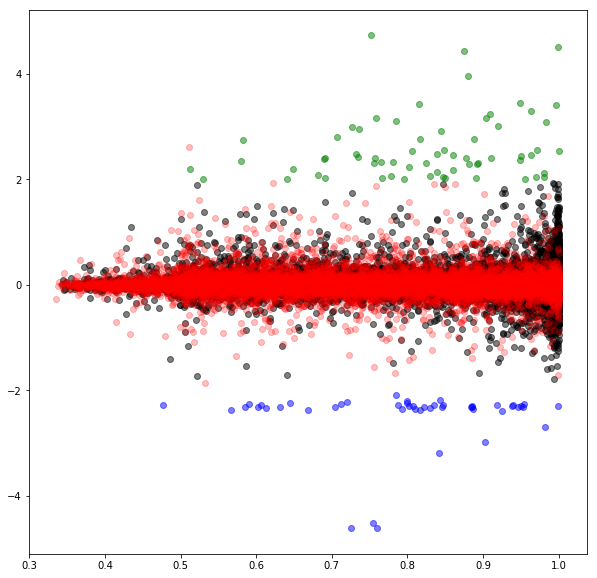

In [16]:
plot_conf_matrix(clf_l1_LR)

In [17]:
print(recall_score(data['zestimate_type'], clf_l1_LR.predict(X), average='weighted'))
print(precision_score(data['zestimate_type'], clf_l1_LR.predict(X), average='weighted'))
print(f1_score(data['zestimate_type'], clf_l1_LR.predict(X), average='weighted'))

0.648717806702
0.998735796046
0.785639550294


#### Random Forests 

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf_rf = RandomForestClassifier(max_depth=16, random_state=9, class_weight='balanced')

In [20]:
clf_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=9,
            verbose=0, warm_start=False)

In [21]:
clf_rf.score(X,y)

0.99690944336748821

In [22]:
confusion_matrix(data['zestimate_type'], clf_rf.predict(X), labels=[1,2,3])

array([[   37,    10,     0],
       [  215, 89906,    41],
       [    0,    13,    53]])

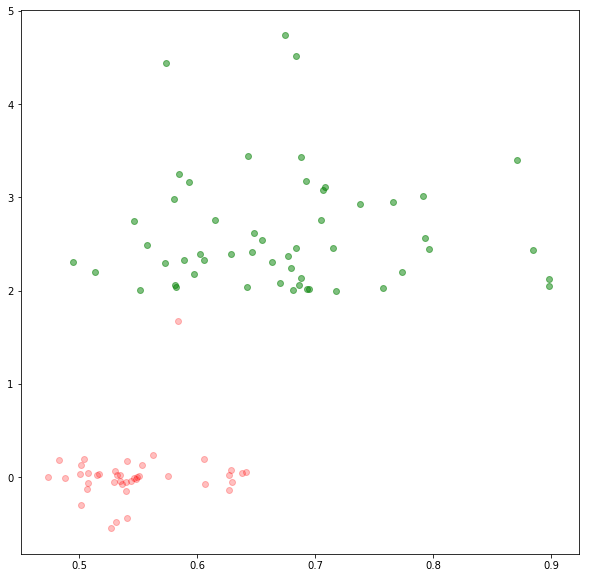

In [23]:
plot_conf_matrix(clf_rf, classes=3)

In [75]:
print(recall_score(data['zestimate_type'], clf_rf.predict(X), average='weighted'))
print(precision_score(data['zestimate_type'], clf_rf.predict(X), average='weighted'))
print(f1_score(data['zestimate_type'], clf_rf.predict(X), average='weighted'))

0.96633619496
0.998488482893
0.981705954631


### Predict on properties data frame

In [120]:
model = clf_rf
probabilities = None
for i in range(int(properties.shape[0] / 100000)):   
    # get current test features
    current_test_feats = feature_pipeline.transform(properties.iloc[i*100000:(i+1)*100000])
    
    # predict on current test obs
    current_probs = DataFrame(model.predict_proba(current_test_feats), columns=[1,2,3],
                          index = np.arange(i*100000,(i+1)*100000))
    
    if probabilities is not None:
        probabilities = pd.concat([probabilities, current_probs])
    else:
        probabilities = current_probs

#  fencepost problem
current_test_feats = feature_pipeline.transform(properties.iloc[2900000:])
current_probs = DataFrame(model.predict_proba(current_test_feats), columns=[1,2,3],
                      index = np.arange(2900000,2985217))
probabilities = pd.concat([probabilities, current_probs])

In [121]:
del properties
import gc
gc.collect()

10021

In [122]:
overestimate_probs = pd.read_csv(maindir + "/data/properties_2016.csv/properties_2016.csv", usecols=['parcelid'])
overestimate_probs = pd.concat([overestimate_probs, probabilities], axis=1)
overestimate_probs.head()

,parcelid,1,2,3
0,10754147,0.000000,0.900907,0.099093
1,10759547,0.024737,0.945903,0.029360
2,10843547,0.000000,0.900389,0.099611
3,10859147,0.000000,0.906845,0.093155
4,10879947,0.024737,0.945903,0.029360


In [123]:
overestimate_probs.shape

(2985217, 4)

In [124]:
overestimate_probs.to_csv("/home/anerdi/Desktop/Zillow/twostagemodel/zestimatetype_probs_rf_balanced.csv.gz", 
                          index=False, compression="gzip")